In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

we just extracted the PacBio data read-ids, or how they call them `qnames` https://pacbiofileformats.readthedocs.io/en/3.0/BAM.html#qname-convention

we did it like so:
```
samtools view -@2 m54328_190622_144736.subreads.bam | cut -f1 > m54328_190622_144736.subreads.csv
samtools view -@2 m54328_190622_144736.scraps.bam | cut -f1 > m54328_190622_144736.scraps.csv
```

it actually takes >~ 30 mins ! whatever ...

In [2]:
scraps = "../data/m54328_190622_144736.scraps.ids.csv"
subreads = "../data/m54328_190622_144736.subreads.ids.csv"
ccs = "../data/ccs_statistics.csv.zip"

scraps_sam = "../data/m54328_190622_144736.scraps.short.sam"
subreads_sam = "../data/m54328_190622_144736.subreads.short.sam"

scraps = pd.read_csv(scraps, header=None, squeeze=True)
subreads = pd.read_csv(subreads, header=None, squeeze=True)
ccs = pd.read_csv(ccs, squeeze=True)

scraps_sam = pd.read_csv(scraps_sam, header=None, squeeze=True,sep='\t')
subreads_sam = pd.read_csv(subreads_sam, header=None, squeeze=True,sep='\t')


PacBio read id : `{movieName}/{holeNumber}/{qStart}_{qEnd}`

CCS read id structure is: `{movieName}/{holeNumber}/ccs`

Now let's extract the `holeNumber` (aka `wellid`) and `qStart`,`qEnd` information from read-IDs

we'll start with the consensus stuff (CCS), it does not have `qStart/Stop` in the read-ID, though


Here are some additional fileds that one can extract from the `scrap` output `.bam`:
```
'np', 'qe', 'qs', 'rq', 'sn', 'zm', 'RG', 'sc', 'sz'
```

and here are for the `subread` output `.bam`-s:
```
'cx', 'np', 'qe', 'qs', 'rq', 'sn', 'zm', 'RG'
```

!!!These are per-read type of flags
there are also per-nucleotide type of flags - too big to deal with right now ...

explanations for [COMMON flags](https://pacbiofileformats.readthedocs.io/en/5.1/BAM.html#use-of-read-tags-for-per-read-base-information) (subreads and scraps share):

\[redundant and useless ones\]
1. `qs`, `qe` - `qStart` and `qEnd` - as simple as that - should coincide whatever is in the `readID`, aka `qName` ...
2. `zm` - ID of the well (hole, etc - whatever corresponds to the single nucleotide reading enzyme - polymerase) - should correspond to `qName` ...
3. `np` - number of passes - should be `1` for scraps and subreads everywhere - important only for CCS ?!

\[interesting ones\]
4. `rq` - read quality/accuracy - predicted, whatever that means, `0.<rq<1.`
5. `sn` - signal to noise per `ACGT`(in that order) - over this HQ region
6. `RG` - read group ... [hard to interpret](https://pacbiofileformats.readthedocs.io/en/5.1/BAM.html#use-of-headers-for-file-level-information)

[SCRAPE-specific ones](https://pacbiofileformats.readthedocs.io/en/5.1/BAM.html#how-to-annotate-scrap-reads):
1. `sz` - ZMW classification: N-normal?!, C-control?!, M-malformed?!, or S-sentinel
2. `sc` - scrap region annotation: A-adapter, B-barcode, L-LQRegion(low quality region - part of HQ or not ...), F-filtered (undesirable subreads - artifactual wtf?! or too short )?! - require exploration ...

SUBREAD-specific ones:
1. `cx` - [subread context](https://pacbiofileformats.readthedocs.io/en/5.1/BAM.html#subread-local-context) - location with respect to adapter/barcode `+` or `-` pass  ...

In [168]:
# extract the required CCS information ...
ccs_df = ccs['qname']. \
                str. \
                extract(r'(.+)\/(.+)\/ccs'). \
                rename({0:"cellid", 1:"zm"},axis=1)
ccs_df = ccs_df.astype({'zm':int})
ccs_df["ql_ccs"] = ccs['qlen'].astype(int)
ccs_df["np_ccs"] = ccs['npasses'].astype(int)

ccs_df = ccs_df.set_index('zm')[["ql_ccs","np_ccs"]]

print(ccs_df.index.dtype)
print(ccs_df.dtypes)
print(ccs_df.shape)

int64
ql_ccs    int64
np_ccs    int64
dtype: object
(1709, 2)


### a little function to extract some basic per-read info from the extended SAM file ...

In [91]:
def process_col_sam(col, sep=':'):
    """
    assuming SAM entry format `header:data_type:value`
    extract data from a given column
    """
    df = col.str.split(sep,expand=True)
    # extract a header, assuming it's uniq:
    header = df[0].unique()
    assert len(header) == 1
    header, = header
    # extract data_type, assuming it's uniq:
    dtype = df[1].unique()
    assert len(dtype) == 1
    dtype, = dtype
    # interpret dtype:
    dtype = {"i":"int","f":"float"}[dtype] if dtype in list("fi") else "str" 
    # extract value
    vals = df[2].astype(dtype)
    return vals.rename(header)
    
# meaningful columns from both scraps and subreads ...
scrap_cols_i = range(9,len(scraps_sam.columns))
subreads_cols_i = range(9,len(subreads_sam.columns))

    
scrap_sam_df = pd.concat([process_col_sam(scraps_sam[i]) \
                           for i in scrap_cols_i],
                         axis=1)
subreads_sam_df = pd.concat([process_col_sam(subreads_sam[i]) \
                           for i in subreads_cols_i],
                         axis=1)

scrap_sam_df['type'] = 'scrap'
subreads_sam_df['type'] = 'subread'

# calculate a scrapeand/or subread region length ...
scrap_sam_df["ql"] = \
    scrap_sam_df["qe"].astype(int) - \
        scrap_sam_df["qs"].astype(int)

subreads_sam_df["ql"] = \
    subreads_sam_df["qe"].astype(int) - \
        subreads_sam_df["qs"].astype(int)

### 0. Let's find out which features are constant across `ZMW`-s ...

* rq - is it per ZMW ?
* sn - signal to noise per ACGT(in that order) - over this HQ region - so is it per ZMW ?
* RG - read group ... hard to interpret ?


* sz - ZMW classification: should be per ZMW, right ?!
* sc - scrap region annotation - should not be per ZMW ...

#### check common features (sub and scrap) first: `rq`, `sn`

In [93]:
# concat scraps and subreads to test some of the ZMW hypothesis:
# bring in `qe` - as a negative control ...
scr_sub_df = pd.concat(
    [scrap_sam_df[['rq','sn','qe','zm','type','ql']],subreads_sam_df[['rq','sn','qe','zm','type','ql']]],
    ignore_index=True,
    verify_integrity=True,
    sort=True)



scr_sub_grp = scr_sub_df.groupby('zm')

# sn should be the same accross ZMW ...
print("ACGT sn (signal/noise) should be the same accros a ZMW:")
print( (scr_sub_grp['sn'].nunique()==1).all() )

print()

# rq should be the same accross ZMW ...
print("read quality rq should be same accross ZMW as well:")
print( (scr_sub_grp['rq'].nunique()==1).all() )

print()

# qe should NOT be the same accross ZMW ...
print("qe should NOT be same accross ZMW:")
print( (scr_sub_grp['qe'].nunique()==1).all() )

ACGT sn (signal/noise) should be the same accros a ZMW:
True

read quality rq should be same accross ZMW as well:
True

qe should NOT be same accross ZMW:
False


#### subread-specific ...

In [8]:
sub_grp = subreads_sam_df.groupby('zm')
# cx should NOT be the same accross ZMW ...
print("cx should NOT be same accross ZMW:")
print( (sub_grp['cx'].nunique()==1).all() )


cx should NOT be same accross ZMW:
False


#### scrap-specific ...

In [9]:
scr_grp = scrap_sam_df.groupby('zm')
# qs should NOT be the same accross ZMW ...
print("qs start should NOT be same accross ZMW:")
print( (scr_grp['qs'].nunique()==1).all() )

print()

# sc should NOT be the same accross ZMW ...
print("sc should NOT be same accross ZMW:")
print( (scr_grp['sc'].nunique()==1).all() )




qs start should NOT be same accross ZMW:
False

sc should NOT be same accross ZMW:
False


### 1. SAM question - is `RG` informative ?

In [10]:
print(subreads_sam_df['RG'].unique())
print(scrap_sam_df['RG'].unique())

['085babce']
['f97bfb12']


#### No  - `RG` isn't informative - it is a unique value for subreads and scraps, whatever ...

## the rest is done in a per-`ZMW` manner, i.e. groupby `ZMW` - then analyze ...

### 2. `rq` - read quality - what is it? should be (0,1) ...

Text(0, 0.5, '#')

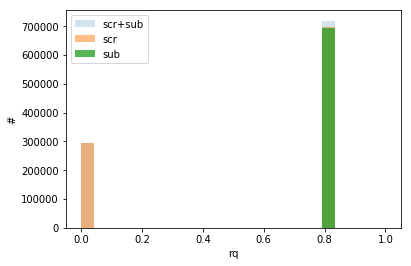

In [23]:
bins = np.linspace(0,1,25)

scr_sub_grp['rq'].first().hist(bins=bins,label="scr+sub",alpha=0.2,log=False)
scr_grp['rq'].first().hist(bins=bins,label="scr",alpha=0.5,log=False)
sub_grp['rq'].first().hist(bins=bins,label="sub",alpha=0.8,log=False)
ax = plt.gca()
ax.legend(loc='best')
ax.grid(False)
ax.set_xlabel('rq')
ax.set_ylabel('#')
# plt.legend()
# plt.grid(False)


### even within a single well it is either `0` or `0.8` ... - what would that mean ?
#### There were other values in the Ellen's CCS analysis PDF - what does that imply ?!

### 3. what about this `sn` - signal to noise , grouped by nucleotide type ...

In [107]:
#ACGT
acgt = dict(zip([1,2,3,4],list('ACGT')))
acgt_dt = dict(zip(list('ACGT'),[float]*4))

# sn-s by scrap and subreads ...
sn_df = scr_sub_df.groupby(['zm','type']).agg({'sn':"first",'ql':sum})
sn_df = pd.concat([sn_df['ql'],sn_df['sn'].str.split(',',expand=True).rename(acgt, axis=1).astype(acgt_dt)[list('ACGT')]],axis=1)
# sn_df = scr_sub_df.groupby(['zm','type'])['sn'].first().str.split(',',expand=True).rename(acgt, axis=1).astype(acgt_dt)
sn_df = sn_df.reset_index()

# sn-s by scrap ...
scr_sn_df = scrap_sam_df.groupby(['zm','sc']).agg({'sn':"first",'ql':sum})
scr_sn_df = pd.concat([scr_sn_df['ql'],scr_sn_df['sn'].str.split(',',expand=True).rename(acgt, axis=1).astype(acgt_dt)[list('ACGT')]],axis=1)
# scr_sn_df = scrap_sam_df.groupby(['zm','sc'])['sn'].first().str.split(',',expand=True).rename(acgt, axis=1).astype(acgt_dt)
scr_sn_df = scr_sn_df.reset_index()

# scrap_sn = scrap_sam_df['sn'].str.split(',',expand=True).rename(acgt, axis=1)
# scrap_sn['rq'] = scrap_sam_df['rq']
# scrap_sn['sc'] = scrap_sam_df['sc']
# scrap_sn['sz'] = scrap_sam_df['sz']
# subreads ...
# subreads_sn = subreads_sam_df['sn'].str.split(',',expand=True).rename(acgt, axis=1)
# subreads_sn['cx'] = subreads_sam_df['cx']
# scrap_sn[list('ACGT')].astype(acgt_dt).max()
# subreads_sn[list('ACGT')].astype(acgt_dt).min()

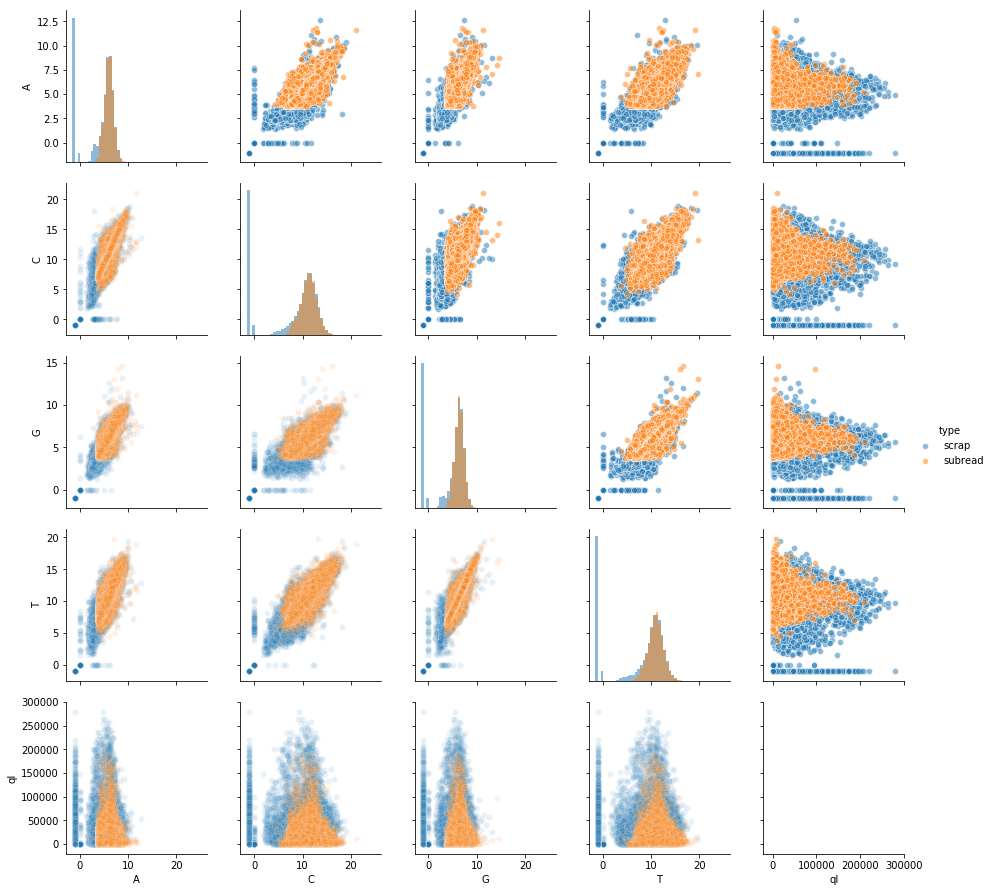

In [108]:
bins=np.linspace(-1.5,25,50)
# just looking at a pairwise relationship between signal-to-noise fro ACTG ...
# whatever that means ...
g = sns.PairGrid(sn_df.sample(frac=0.05), vars=list('ACGT')+['ql'], hue='type', diag_sharey=False)
g.map_lower(sns.scatterplot,alpha=0.1)
g.map_upper(sns.scatterplot,alpha=0.5)
g.map_diag(plt.hist,alpha=0.5,bins=bins)
g.add_legend()

### it looks like `sn` is threasholded somehow for subreads - i.e. scraps have much lower signal to noise at times ...
### question - how does this look like in the scrap category breakdown ...

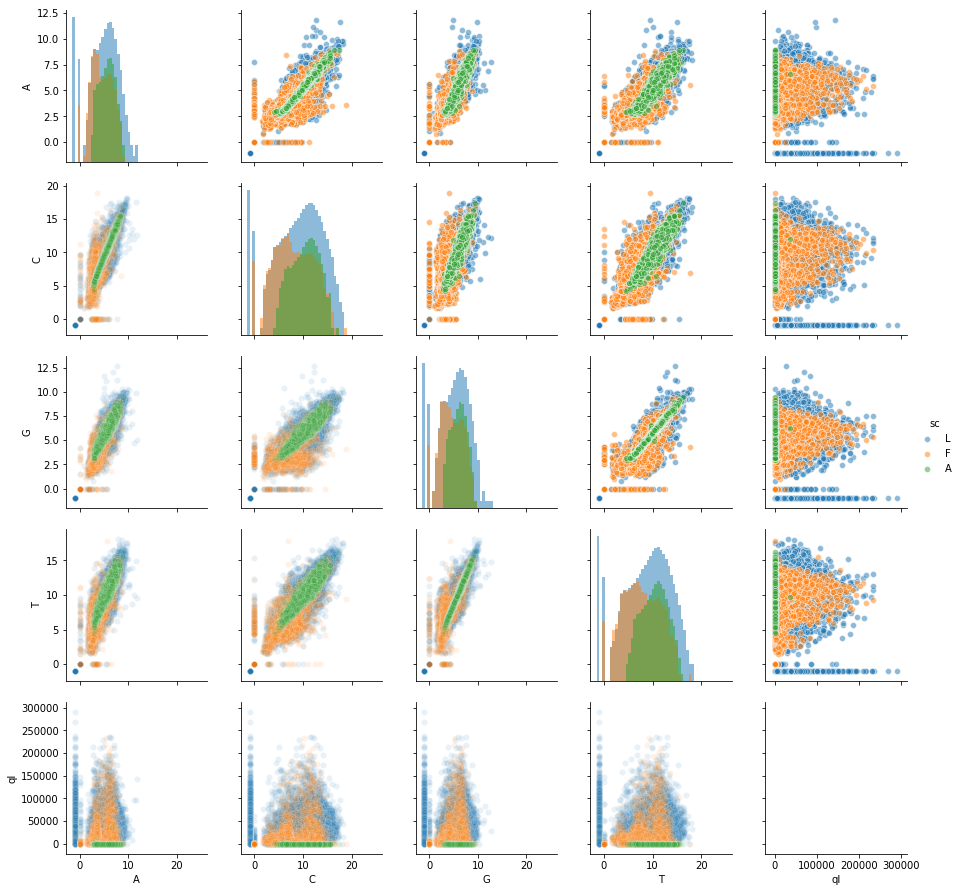

In [110]:
# SOME OTHER TYPES OF PAIRWISE SCATTERS ...

# just looking at a pairwise relationship between signal-to-noise fro ACTG ...
# whatever that means ...
g = sns.PairGrid(scr_sn_df.sample(frac=0.05), vars=list('ACGT')+['ql'], hue='sc', diag_sharey=False)
g.map_lower(sns.scatterplot,alpha=0.1)
g.map_upper(sns.scatterplot,alpha=0.5)
g.map_diag(plt.hist,alpha=0.5,bins=bins,log=True)
g.add_legend()

# # just looking at a pairwise relationship between signal-to-noise fro ACTG ...
# # whatever that means ...
# g = sns.PairGrid(scrap_sn.sample(frac=0.01)[list('ACGT')+['rq']].astype(acgt_dt), vars=list('ACGT'), hue='rq', diag_sharey=False)
# g.map_lower(sns.kdeplot)
# g.map_upper(sns.scatterplot)
# g.map_diag(sns.kdeplot, lw=3)

# g = sns.PairGrid(scrap_sn.sample(frac=0.062)[list('ACGT')+['sc']].astype(acgt_dt), vars=list('ACGT'), hue='sc', diag_sharey=False)
# # g.map_lower(sns.kdeplot)
# g.map_upper(sns.scatterplot, alpha=0.5)
# g.map_diag(plt.hist,bins=bins,alpha=0.5,log=False)
# g.add_legend()

# bins=np.linspace(-1.5,25,50)
# pd.plotting.scatter_matrix(scrap_sn.sample(frac=0.01)[list('ACGT')].astype(acgt_dt),hist_kwds={'bins':bins})
# pd.plotting.scatter_matrix(subreads_sn.sample(frac=0.1)[list('ACGT')].astype(acgt_dt),hist_kwds={'bins':bins})

 - `A` - adapters are good quality (high signal to noise),
 - `F` - filtered, artifactual and/or short are mostly "bad"
 - `L` - supposedly LowQ regions (is it still inside ZMW?!) are all over the place including really bad

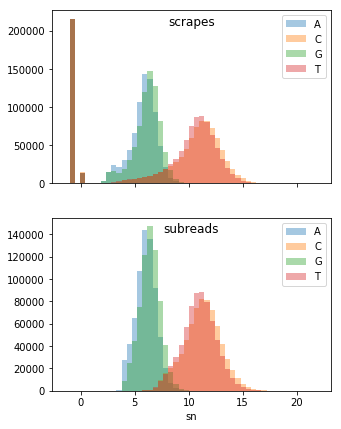

In [80]:
bins=np.linspace(-1.5,22,50)

f,(axtop,axbot) = plt.subplots(nrows=2,sharex=True,figsize=(5,7),squeeze=True)


for l in 'ACGT':
    sn_df[sn_df['type']=='scrap'][l].astype('float').hist(bins = bins,alpha=0.4,label=l,ax=axtop)
    sn_df[sn_df['type']=='subread'][l].astype('float').hist(bins = bins,alpha=0.4,label=l,ax=axbot)    
# ax = plt.gca()
axtop.set_title("scrapes",pad=-15)
axtop.grid(False)
axtop.legend()

axbot.set_title("subreads",pad=-15)
axbot.set_xlabel("sn")
axbot.grid(False)
axbot.legend()



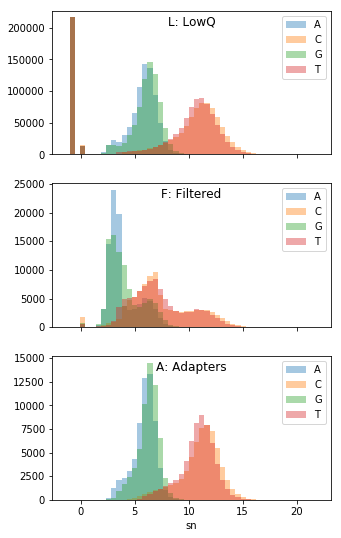

In [87]:

f,(axtop,axmid,axbot) = plt.subplots(nrows=3,sharex=True,figsize=(5,9),squeeze=True)

for l in 'ACGT':
    scr_sn_df[scr_sn_df['sc']=='L'][l].astype('float').hist(bins = bins,alpha=0.4,label=l,ax=axtop)
    scr_sn_df[scr_sn_df['sc']=='F'][l].astype('float').hist(bins = bins,alpha=0.4,label=l,ax=axmid)    
    scr_sn_df[scr_sn_df['sc']=='A'][l].astype('float').hist(bins = bins,alpha=0.4,label=l,ax=axbot)    

axtop.set_title("L: LowQ",pad=-15)
axtop.grid(False)
axtop.legend()

axmid.set_title("F: Filtered",pad=-15)
axmid.grid(False)
axmid.legend()


axbot.set_title("A: Adapters",pad=-15)
axbot.set_xlabel("sn")
axbot.grid(False)
axbot.legend()


/home/venevs/miniconda3/envs/dots-latest/lib/python3.6/site-packages/matplotlib/legend.py:449: UserWarning: The handle <matplotlib.patches.Patch object at 0x7f64b9aefe80> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


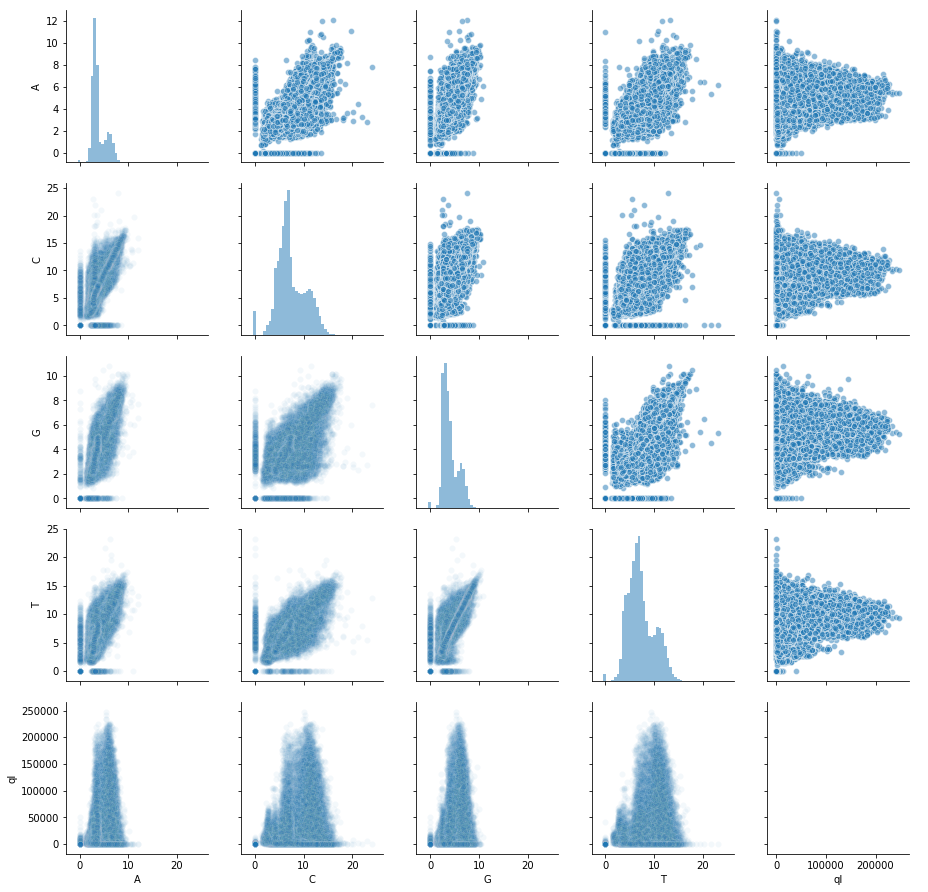

In [111]:
df = scr_sn_df[scr_sn_df['sc']=='F']
g = sns.PairGrid(df, vars=list('ACGT')+['ql'], diag_sharey=False)
g.map_lower(sns.scatterplot,alpha=0.05)
g.map_upper(sns.scatterplot,alpha=0.5)
g.map_diag(plt.hist,alpha=0.5,bins=bins,log=False)
g.add_legend()

### it looks interesting - non-trivial and there is some systematic bias  - but what to make out of it and how to use it - who knows ?...

### we should start merging and comparing them ...

let's merge subreads, scraps and CCS by the `wellid` and just explore it:
 1. what's so special about ~1500 reads that have a CCS, i.e. consensus ?
 2. are there wells with scraps, but no subreads ? how many ?
 3. are there wells with subreads, but no scraps ? how many ? (strange category - how is it possible?)
 4. total number of uniq wells the both scraps and subreads are reffering to - PacBio Sequel has 1M wells ...
 5. how many nucleotides does each well generate ? `total_qlen_scr + total_qlen_sub` - basically ...

In [187]:
scr_sub_df.groupby(['zm','type']).agg({'ql':[min,max,sum,'mean','std'],'type':"count"}).iloc[300:400,:]

ql                                            type
                   min    max    sum          mean           std count
zm      type                                                          
4194544 subread   4248   4248   4248   4248.000000           NaN     1
4194545 scrap    63637  63637  63637  63637.000000           NaN     1
4194546 scrap     3348   3348   3348   3348.000000           NaN     1
4194547 scrap    21085  21085  21085  21085.000000           NaN     1
4194548 scrap       42  19713  19755   9877.500000  13909.497493     2
...                ...    ...    ...           ...           ...   ...
4194601 subread  14628  14628  14628  14628.000000           NaN     1
4194602 scrap      129    129    129    129.000000           NaN     1
        subread  11995  11995  11995  11995.000000           NaN     1
4194603 scrap     1380  21744  25760   8586.666667  11411.877555     3
4194604 scrap     2248  35305  37553  18776.500000  23374.828866     2

[100 rows x 6 columns]

In [178]:
ddf = scr_sub_df[scr_sub_df['type']=='scrap'].groupby(['zm']).agg({'ql':[min,max,sum,'mean','std']})

In [176]:
scr_sub_df

,qe,ql,rq,sn,type,zm
0,26024,2439,0.8,"f,7.08759,13.1376,6.67676,11.3759",scrap,4194368
1,43154,43154,0.8,"f,8.25438,14.9036,8.16628,13.8023",scrap,4194369
2,14803,1713,0.8,"f,4.10741,7.86821,4.80494,8.34923",scrap,4194370
3,38444,38444,0.8,"f,6.1551,11.5816,7.74511,13.2828",scrap,4194371
4,5622,5622,0.0,"f,3.25568,8.60389,2.98389,6.44324",scrap,4194372
...,...,...,...,...,...,...
2596130,20951,19755,0.8,"f,7.27389,13.7389,7.2193,12.3741",subread,74908657
2596131,33926,33926,0.8,"f,5.5019,10.603,5.88689,10.0879",subread,74908659
2596132,29173,162,0.8,"f,8.01838,14.8124,7.71053,13.1098",subread,74908661
2596133,39368,1347,0.8,"f,6.49608,12.1776,7.44398,12.7446",subread,74908663


/home/venevs/miniconda3/envs/dots-latest/lib/python3.6/site-packages/matplotlib/legend.py:449: UserWarning: The handle <matplotlib.patches.Patch object at 0x7f646eccd710> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


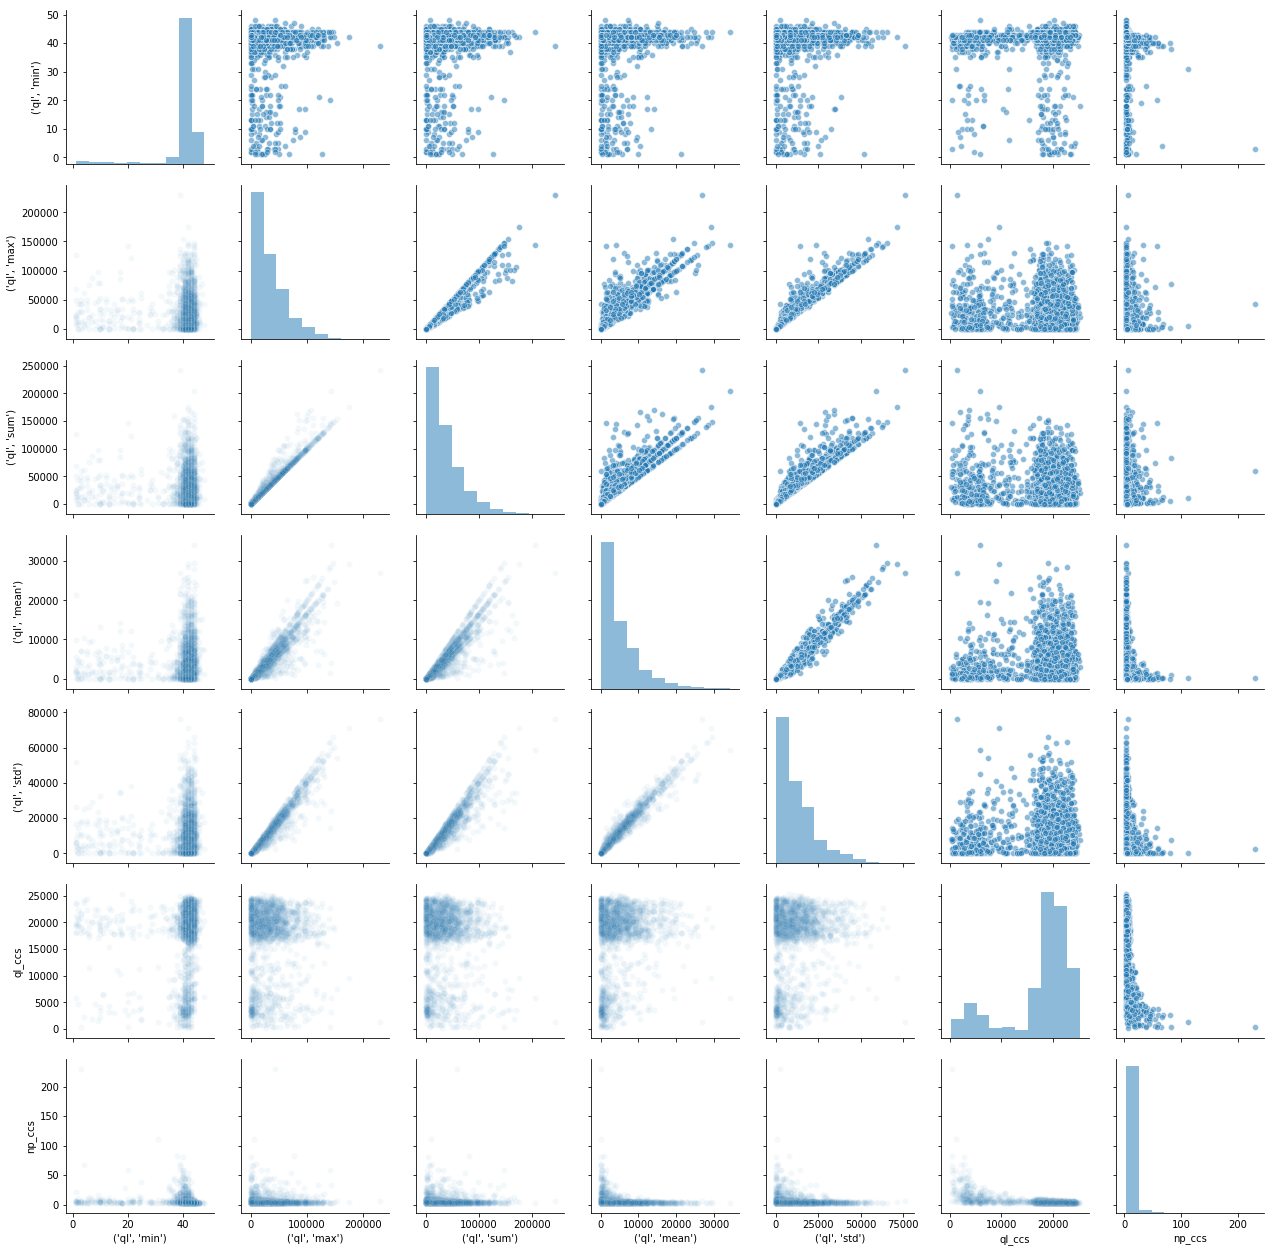

In [179]:
df = ddf.merge(ccs_df,left_index=True,right_index=True)

g = sns.PairGrid(df, diag_sharey=False)
g.map_lower(sns.scatterplot,alpha=0.05)
g.map_upper(sns.scatterplot,alpha=0.5)
g.map_diag(plt.hist,alpha=0.5,log=False)
g.add_legend()

In [140]:
bins = np.geomspace(10,ddf[('ql', 'max')].max(),100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f64c83c8f60>,
      dtype=object)

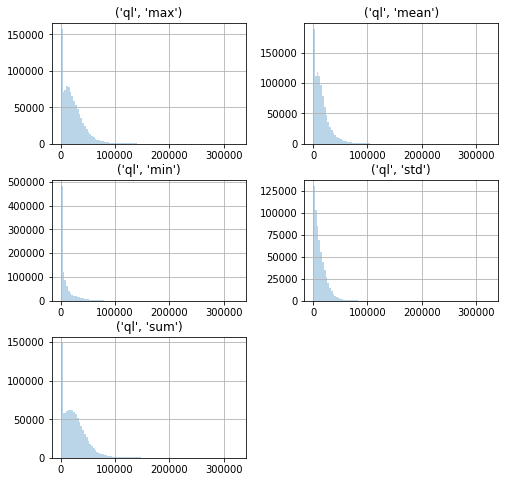

In [192]:
bins = np.linspace(0,ddf[('ql', 'max')].max(),100)
ddf.hist(bins=bins,log=False,alpha=0.3,figsize=(8,8))

No handles with labels found to put in legend.


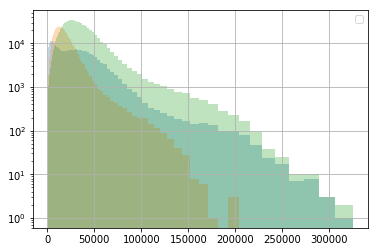

In [134]:
ddf[('ql', 'min')].hist(bins=bins,log=True,alpha=0.3)
ddf[('ql', 'std')].hist(bins=bins,log=True,alpha=0.3)
ddf[('ql', 'max')].hist(bins=bins,log=True,alpha=0.3)
plt.legend()

In [ ]:
sub_scr = subread_df.merge(scrap_df,'outer',left_index=True,right_index=True,suffixes=('_sub','_scr'))
sub_scr_ccs = _.merge(ccs_df,'outer',left_index=True,right_index=True )

### 1. what's so special about those that have consensus ? ...

In [ ]:
ccs_special = sub_scr_ccs[sub_scr_ccs['npasses_ccs']>0]
ccs_special

observations - not all of the subreads go into CCS, scaraps looks uniform in size - adaptors only ?!

### 2. wells with scraps but without subreads ...

In [ ]:
scr_without_sub = sub_scr_ccs[(sub_scr_ccs['npases_scr']>0)&(sub_scr_ccs['npases_sub'].isnull())]

scr_without_sub

number of passes (pieces) and total number of nucleotides in such scrapes ...

In [ ]:
scr_without_sub['qlen_scr'].hist(log=True,bins=200)
scr_without_sub['npases_scr'].value_counts()

 - ~300'000 well did not yield any subreads ...
 - a lot of them are short and have 1 pass, but there multi-pass ones with a ton of nucleotides ...

### 3. wells with subreads but without scraps ... wtf is that ?

In [ ]:
sub_without_scr = sub_scr_ccs[(sub_scr_ccs['npases_sub']>0)&(sub_scr_ccs['npases_scr'].isnull())]

sub_without_scr

number of passes (pieces) and total number of nucleotides in such subreads ...

In [ ]:
sub_without_scr['qlen_sub'].hist(log=True,bins=100)
sub_without_scr['npases_sub'].value_counts()

 - a-ha! these are all 1-pass subreads that didn't have their adaptors sequences ?! or whatever ...
 - there are ~20'000 of them ...

### 4. total number of uniq wells the both scraps and subreads are reffering to - PacBio Sequel has 1M wells ...

In [ ]:
len(sub_scr_ccs)

https://www.pacb.com/products-and-services/sequel-system/

Sequel has 1M wells - and we got a little over 1M of unique wellids

- where does the surplus come from  ?!

is 1M an approximate number or what ...

### 5. how many nucleotides does each well generate ? total_qlen_scr + total_qlen_sub - basically ...

In [ ]:
nucs = sub_scr_ccs['qlen_scr'].fillna(0)+sub_scr_ccs['qlen_sub'].fillna(0)

In [ ]:
nucs.hist(log=False,bins= np.geomspace(1000,200000))

## Some older functions (retired...)

#### create a little function to extract qname info and some basic stats from raw data ...

this would work both for subreads and for scraps

 - we will be extracting `wellid`,  and `qstart` , `qstop`
 - calculating `qlen`, which is `qstop - qstart`
 - and then grouping by `wellid` to generate some more stats on the `qlen` of different fragments ...

In [113]:
# def _check_sam_cols(df_sam, cols_to_check, sep=':'):
#     """
#     given a list of columns to check, go over them
#     and check if every column refers to the same data
#     i.e., has the same header, assuming following format:
#     `header:data-type:value`
#     """
#     col_heads = []
#     for col in cols_to_check:
#         col_head_val = df_sam[col].str.split(sep).str[0].sort_values().unique()
#         # make SAM is intact - 1 type of entries per 1 column only ...
#         assert len(col_head_val) == 1
#         # extract that single value and append it to column headers
#         _, = col_head_val
#         col_heads.append(_)
#     return col_heads

def wellstats_from_sam(samdf):
    """
    """
    # calculate span
    samdf["ql"] = \
        samdf["qe"].astype(int) - \
            samdf["qs"].astype(int)
    
    # # just a little test ...
    # print(raw_qnames_df[raw_qnames_df["wellid"]=="25953225"])

    # group it by WellID(zm) and collect the qlen
    # npases, qlen mean and std ...
    
    _ = samdf[['zm','ql']].groupby('zm').sum()
    # wellid becomes an index and assigning new columns like that
    # should be taking care of an index matching just fine ...
    _['np'] = samdf['zm'].value_counts()
    
    _['rq'] = samdf[['zm','rq']].groupby('zm').mean()

    _['ql_med'] = samdf[['zm','ql']].groupby('zm').median()
    _['ql_std'] = samdf[['zm','ql']].groupby('zm').std()
    # _.sort_values(by="npases")
    # print(raw_qnames_df.shape)
    return _

def wellstats_from_readid(raw_qnames):
    """
    given a df or series of qnames (pacbio readids)
    this function would generate a df with a bunch
    of columns describing output of each well ...
    """
    raw_qnames_df = raw_qnames. \
                        str. \
                        extract(r'(.+)\/(.+)\/(\d+)\_(\d+)'). \
                        rename({0:"cellid", 1:"wellid",2:"qstart",3:"qstop"},axis=1)
    # calculate span
    raw_qnames_df["qlen"] = \
        raw_qnames_df["qstop"].astype(int) - \
            raw_qnames_df["qstart"].astype(int)
    
    # # just a little test ...
    # print(raw_qnames_df[raw_qnames_df["wellid"]=="25953225"])

    # group it by WellID and collect the qlen
    # npases, qlen mean and std ...
    
    _ = raw_qnames_df[['wellid','qlen']].groupby('wellid').sum()
    # wellid becomes an index and assigning new columns like that
    # should be taking care of an index matching just fine ...
    _['npases'] = raw_qnames_df['wellid'].value_counts()
    _['qlen_avg'] = raw_qnames_df[['wellid','qlen']].groupby('wellid').median()
    _['qlen_std'] = raw_qnames_df[['wellid','qlen']].groupby('wellid').std()
    # _.sort_values(by="npases")
    # print(raw_qnames_df.shape)
    return _